<a href="https://colab.research.google.com/github/agme2019/SciML-Experiments/blob/main/Agnivo_copy_of_Tiny_Stories_with_NanoGPT_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we’ll explore how to train a lightweight NanoGPT on the Tiny Stories dataset. NanoGPT, developed by Andrej Karpathy, is a simplified variant of GPT designed for simplicity and speed. Our goal is to generate creative and coherent text based on the input data. I will also use Wandb library to track the experiments on the model.

# Import Libraries

In [1]:
# Clone the NanoGPT
!git clone https://github.com/karpathy/nanoGPT.git
!pip install tiktoken

Cloning into 'nanoGPT'...
remote: Enumerating objects: 682, done.
remote: Total 682 (delta 0), reused 0 (delta 0), pack-reused 682 (from 1)
Receiving objects: 100% (682/682), 952.47 KiB | 2.94 MiB/s, done.
Resolving deltas: 100% (385/385), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import nanoGPT.model as GPT
import wandb
import os

In [3]:
# from kaggle_secrets import UserSecretsClient
# # Load API keys https://www.kaggle.com/discussions/product-feedback/114053
# secret_label = "WANDB_API_KEY"
my_secret = "c2e3619f245387906ce0bd58733dc79534a116bc"

In [4]:
class GPTConfig: # Model config from NanoGPT
    block_size: int = 256 # increased from 256
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 8 # same
    n_embd: int = 192 # changed from 384
    dropout: float = 0.2
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

config = GPTConfig

In [5]:
wandb_config = {k:v for k,v in vars(config).items() if not callable(getattr(config, k)) and not k.startswith("__")} # Creating Wandb hyperparameters config for tracking experiements
wandb_config

{'block_size': 256,
 'vocab_size': 50304,
 'n_layer': 12,
 'n_head': 8,
 'n_embd': 192,
 'dropout': 0.2,
 'bias': True}

In [6]:
wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Tiny Stories datasets and preprocessing

TinyStories, a synthetic dataset of short stories that only contain words that a typical 3 to 4-year-olds usually understand, generated by GPT-3.5 and GPT-4. We show that TinyStories can be used to train and evaluate LMs that are much smaller than the state-of-the-art models (below 10 million total parameters)

In [7]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00


In [8]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [9]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

# Training

In [ ]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [ ]:
# Training Config

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 600000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

nanoGPT = GPT.GPT(config)
##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(nanoGPT.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

number of parameters: 15.00M


<ipython-input-12-796f8fa3ac05>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
wandb.init(project="nanogpt-tinystories", name="nanoGPT-sml-longer", config=wandb_config)

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

for epoch in tqdm(range(max_iters)):
    if epoch%eval_iters == 0 and epoch != 0:
        losses = estimate_loss(nanoGPT)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        wandb.log({
                "epoch": epoch,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": optimizer.param_groups[0]['lr']
            })

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(nanoGPT.state_dict(), best_model_params_path)

    X,y = get_batch("train")

    with ctx:
        logits, loss = nanoGPT(X, y)
        loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(nanoGPT.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()


wandb.finish()

wandb: Currently logged in as: nisargbhavsar. Use `wandb login --relogin` to force relogin


  0%|          | 0/600000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 10.0973, val loss 10.1035
The current learning rate: 0.00007


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 9.6385, val loss 9.6430
The current learning rate: 0.00010
Epoch 1500: train loss 9.1469, val loss 9.1484
The current learning rate: 0.00010
Epoch 2000: train loss 8.6391, val loss 8.6409
The current learning rate: 0.00010
Epoch 2500: train loss 8.1683, val loss 8.1711
The current learning rate: 0.00010
Epoch 3000: train loss 7.7617, val loss 7.7663
The current learning rate: 0.00010
Epoch 3500: train loss 7.3623, val loss 7.3649
The current learning rate: 0.00010
Epoch 4000: train loss 7.0005, val loss 7.0000
The current learning rate: 0.00010
Epoch 4500: train loss 6.6930, val loss 6.6931
The current learning rate: 0.00010
Epoch 5000: train loss 6.3983, val loss 6.3975
The current learning rate: 0.00010
Epoch 5500: train loss 6.1532, val loss 6.1528
The current learning rate: 0.00010
Epoch 6000: train loss 5.9174, val loss 5.9209
The current learning rate: 0.00010
Epoch 6500: train loss 5.7013, val loss 5.7066
The current learning rate: 0.00010
Epoch 7000: trai

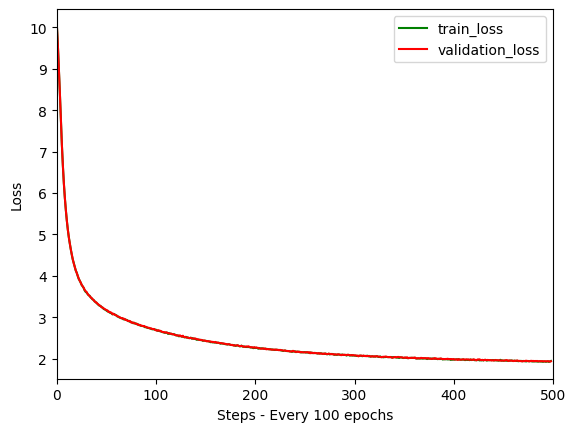

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]
plt.plot(train_loss_list_converted, 'g', label = 'train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.xlim(0, 500)
plt.show()
np.savetxt('train_loss.csv', train_loss_list_converted, delimiter=',')



# Inference

In [ ]:
#Load the model
nanoGPT = GPT.GPT(config)
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


number of parameters: 15.00M


<ipython-input-18-d4e888674873>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)

<All keys matched successfully>

In [ ]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = nanoGPT.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. It was a different shape, and it was her name. It was beautiful. She wanted to make lots of cool things with it.

So she got to work and worked together. She put the pumpkin up on the circle and cracked it and shone like a big bubble.

Then, the little orange made a frog. She was so happy. She felt like a huge bird of a big berry.

The little purple frog was no longer lonely. She thought it would be more fun to finish. She grabbed a big paper basket with all sorts of gem and markers. She stood in sign to all the berry and smiled, feeling so happy.

On day, two of twinkling: One of them had a fight:bugs: the overlook: Tom's joke! But the putny bunns and a berry, it was a friendly crocod Clarey integrating. Tom's mom and she wanted to make the little bear, bigger and mottoet


In [ ]:
from google.colab import runtime
runtime.unassign()